# Validate ice layer and properties

Here I try to make sure I'm computing ice properties correctly (which also entails figuring out which layer of the ice we're in when tilt is enabled).

In [18]:
from itertools import product
from os.path import *
from os import *
import cPickle as pickle
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from icecube.dataclasses import *
from icecube import *
from icecube.icetray import *
from icecube.clsim import MakeIceCubeMediumProperties
sys.path.append(expandvars('$I3_SRC/clsim/python/util'))
from GetIceTiltZShift import GetIceTiltZShift, I3CLSimScalarFieldIceTiltZShift

In [2]:
gcd = pickle.load(file('../data/GeoCalibDetectorStatus_IC86.55697_corrected_V2.pkl', 'rb'))
geo = gcd['geo']

In order to check that my sign conventions are correct, I'll attempt to reproduce Figure 14 from
https://icecube.wisc.edu/~dima/work/WISC/ppc/spice/paper/a.pdf

In [19]:
ice_model = 'spice_mie'
tilt_dir = 225 # deg, from above paper (not given in cfg.txt for spice mie, so probably a default)

In [20]:
zshift = GetIceTiltZShift(
    tiltDirAzimuth=tilt_dir*I3Units.deg,
    tiltDirectory=expandvars(
        '$I3_SRC/ice-models/resources/models/{}'
        .format(ice_model)
    ),
    detectorCenterDepth=1948.07*I3Units.m
)

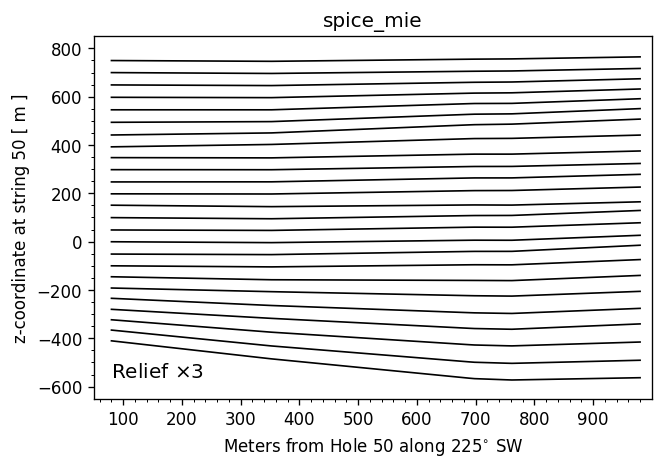

In [17]:
theta = np.deg2rad(tilt_dir)
ct = np.cos(theta)
st = np.sin(theta)

fig, ax = plt.subplots(dpi=120)

drs = np.linspace(80, 980, 100)
for z in np.arange(-450, 800, 50):
    #z = -400
    x50, y50 = geo[50-1, 59, :2]
    zs = []
    for dr in drs:
        x = x50 + dr * ct
        y = y50 + dr * st
        zs.append(z + zshift.GetValue(x, y, z))
    zs = np.array(zs)
    ax.plot(drs, 3*(zs - zs[0]) + zs[0], 'k-', lw=1)
    
ax.set_xlim(50, 1000)
ax.set_ylim(-650, 850)

ax.set_title(ice_model)
ax.set_xticks(np.arange(100, 901, 100), minor=False)
ax.set_xticks(np.arange(60, 1000, 20), minor=True)
ax.set_yticks(np.arange(-600, 801, 200), minor=False)
ax.set_yticks(np.arange(-600, 801, 50), minor=True)
ax.set_xlabel(r'Meters from Hole 50 along %.0f$^{\circ}$ SW' % tilt_dir)
ax.set_ylabel('z-coordinate at string 50 [ m ]')
ax.text(80, -500, r'Relief $\times$3', fontsize=12, va='top', ha='left')
pass

This looks like a very close match to the paper, possibly the start positions are off.
But this is close enough for me to be okay with this, at least for now.

In [9]:
ice_model = 'spice_lea'
tilt_dir = 216 # degrees, from cfg.txt

In [10]:
zshift = GetIceTiltZShift(
    tiltDirAzimuth=tilt_dir*I3Units.deg,
    tiltDirectory=expandvars(
        '$I3_SRC/ice-models/resources/models/{}'
        .format(ice_model)
    ),
    detectorCenterDepth=1948.07*I3Units.m
)

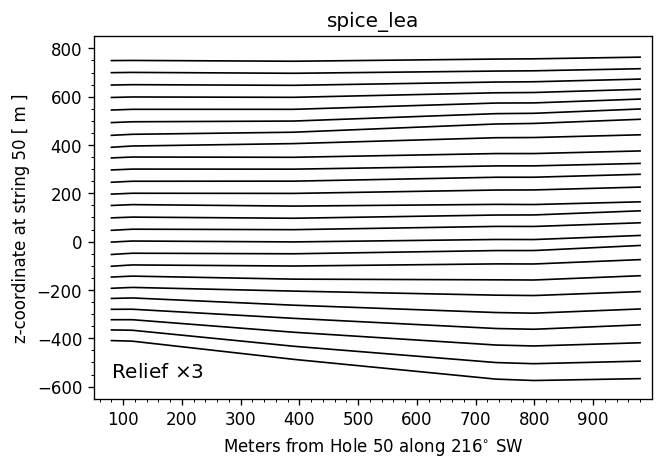

In [14]:
theta = np.deg2rad(tilt_dir)
ct = np.cos(theta)
st = np.sin(theta)

fig, ax = plt.subplots(dpi=120)

drs = np.linspace(80, 980, 100)
for z in np.arange(-450, 800, 50):
    #z = -400
    x50, y50 = geo[50-1, 59, :2]
    zs = []
    for dr in drs:
        x = x50 + dr * ct
        y = y50 + dr * st
        zs.append(z + zshift.GetValue(x, y, z))
    zs = np.array(zs)
    ax.plot(drs, 3*(zs - zs[0]) + zs[0], 'k-', lw=1)
    
ax.set_xlim(50, 1000)
ax.set_ylim(-650, 850)

ax.set_title(ice_model)
ax.set_xticks(np.arange(100, 901, 100), minor=False)
ax.set_xticks(np.arange(60, 1000, 20), minor=True)
ax.set_yticks(np.arange(-600, 801, 200), minor=False)
ax.set_yticks(np.arange(-600, 801, 50), minor=True)
ax.set_xlabel(r'Meters from Hole 50 along %.0f$^{\circ}$ SW' % tilt_dir)
ax.set_ylabel('z-coordinate at string 50 [ m ]')
ax.text(80, -500, r'Relief $\times$3', fontsize=12, va='top', ha='left')
pass

## Which layer is it?

Now I will try to replicate a value or two from table 3 of that paper to make sure that I'm getting which layer is which correct.

Of course what the center of the detector is not explicitly defined in that paper.

And nor are the parameters used listed; $\alpha$, $\kappa$, $A$, and $B$ of "the six parameter model" are referenced as coming from

> M. Ackermann et al. Optical properties of deep glacial ice at the south pole. J. Geophys. Res., 111:D13203, 2006.

but keep in mind that Dima does _not_ use the $D$ and $E$ parameters at all from that model (see end of section 4).

Looking in _Ackermann, et al._, the caption of Table 3 lists equations as

$$b_e(\lambda[{\rm nm}])=(\lambda/400)^{-0.9}b_e(400)$$
and
$$a(\lambda[{\rm nm}]) = (\lambda/400)^{-1.08}a_{\rm dust}(400) + 7\times10^3e^{-6600/\lambda}$$

matching the above with the equations, we obtain the following values:

* $\alpha = 0.9$
* $\kappa = 1.08$
* $A = 7\times10^3$
* $B = 6600$

In Dima's paper, he uses the equations:

$$b_e(\lambda[{\rm nm}])=\left(\frac{\lambda}{400}\right)^{-\alpha}b_e(400)$$
$$a(\lambda) = a_{\rm dust}(400)\cdot\left(\lambda\over400\right)^{-\kappa} + Ae^{-B/\lambda}\cdot(1 + 0.01\cdot\delta_\tau)$$

where there is the additional parameter $\delta_\tau$ which is listed as a function of depth relative to the temperature at the center of the AMANDA detector:

$$\delta_\tau(d) = T(d) - T(1730\,{\rm m})$$
with
$$T = 221.5 - 0.00045319\cdot d + 5.822\cdot 10^{-6}\cdot d^2$$

Note also that all measurements are listed for wavelengths of 400 nm, which also simplifies the equations (so that's fine for my purposes here).

The ice model in that paper is stated to be SpiceMIE.

In [6]:
ice_model = 'spice_mie'
lam = 400 # wavelength in units of nm

I'll get the "center" of the detector for $(x,y)$ (not sure how Dima defines it, I'll just use the average) and I'll pick a $z$ coordinate represented in Table 3 of Dima's paper.

In [7]:
x = geo[:, :, 0].mean()
y = geo[:, :, 1].mean()
#x, y = geo[36-1, 0, :2]
#x, y, = -400, -400
z = -400
#z = 400
x, y, z

(5.870828647761382, -2.5186089166375094, -400)

Let's first obtain the depth of our point for referencing the tables

In [8]:
z_depth = 1948.07 - z
z_depth

2348.0699999999997

You can look this entry up in the table and you see that $1/b_e=32.9$ m and $1/a=118.7$ m.

### Use CLSim to extract ice properties.

First, let's try with the tool that Claudio wrote in CLSim to extract ice properties.

In [9]:
ice_props, ice_params = MakeIceCubeMediumProperties(
    detectorCenterDepth=1948.07*I3Units.m,
    iceDataDirectory=expandvars(
        '$I3_SRC/ice-models/resources/models/{}'
        .format(ice_model)
    ),
    useTiltIfAvailable=True,
    returnParameters=True
)
ice_params

{'anisotropyDirAzimuth': nan,
 'anisotropyMagnitudeAlongDir': nan,
 'anisotropyMagnitudePerpToDir': nan}

In [10]:
zshift = ice_props.GetIceTiltZShift()
zshift.GetValue(x, y, z)

0.6576380263177812

Note that scattering in the paper is given in terms of _effective_ scattering length, $b_e = b \cdot (1 - \langle \cos\theta \rangle)$.

According to Martin Rongen, "[cos theta is] a configuration option, usually we choose 0.9 (although the physical truth is probably closer to 0.94)."

Therefore, $b = 0.1 b_e$... i.e., scattering lengths from the CLSim tool must be multiplied by 10 to effective scattering lengths comparable to those in Dima's paper.

In [11]:
layer_num = int(
    (z + zshift.GetValue(x, y, z) - ice_props.GetLayersZStart())
    / ice_props.GetLayersHeight()
)

print 'layer =', layer_num
print 'scatlen(400 nm) = {:.1f} m'.format(
    10*ice_props.GetScatteringLength(layer_num).GetValue(lam*I3Units.nanometer)
)
print 'abslen(400 nm) = {:.1f} m'.format(
    ice_props.GetAbsorptionLength(layer_num).GetValue(lam*I3Units.nanometer)
)

layer = 45
scatlen(400 nm) = 32.9 m
abslen(400 nm) = 118.7 m


Both values agree that absorption length is 118.7 m.

Now let's try to manually construct the above from Dima's tables and equations in the paper(s).

Note that while Spice Mie on disk has 6 parameters in `icemodel.par`, the paper reports to only use the first four parameters, so I'll use the equation from the paper and these four parameters.

Also note that the file formats are described at http://software.icecube.wisc.edu/documentation/projects/ppc/index.html

In [12]:
rootdir = (
    '/cvmfs/icecube.opensciencegrid.org/py2-v3/Ubuntu_16.04_x86_64/'
    'metaprojects/combo/stable/ice-models/resources/models/{}'
).format(ice_model)

cfg = np.loadtxt(join(rootdir, 'cfg.txt'))
print 'cfg.txt shape:', cfg.shape

oversize_scaling = cfg[0]
efficiency_correction = cfg[1]
liu_scattering_fraction = cfg[2]
mean_cos_scattering_theta = cfg[3]

print 'mean_cos_scattering_theta:', mean_cos_scattering_theta

icemodel_par = np.loadtxt(join(rootdir, 'icemodel.par'))
print 'icemodel.par shape:', icemodel_par.shape
if False: #ice_model == 'spice_mie':
    assert icemodel_par.shape[0] == 6
    alpha, kappa, A, B, D, E = icemodel_par[:, 0].T
    print 'alpha={}, kappa={}, A={}, B={}, D={}, E={}'.format(alpha, kappa, A, B, D, E)
else: # ice_model == 'spice_lea':
    #assert icemodel_par.shape[0] == 4
    alpha, kappa, A, B = icemodel_par[:, 0].T[:4]
    print 'alpha={}, kappa={}, A={}, B={}'.format(alpha, kappa, A, B)
#else:
#    raise ValueError(ice_model)
    
icemodel = np.loadtxt(join(rootdir, 'icemodel.dat'))
print 'icemodel.dat shape:', icemodel.shape

# first column: z layer *depth* midpoints
zlayermidpts = icemodel[:, 0]
# second column: b_e(400) values
be400 = icemodel[:, 1]
# third column: adust(400) values
adust400 = icemodel[:, 2]
# fourth column: delta_tau values
delta_tau = icemodel[:, 3]

cfg.txt shape: (4,)
mean_cos_scattering_theta: 0.9
icemodel.par shape: (6, 2)
alpha=0.898608505726, kappa=1.08410680294, A=6954.09033203, B=6617.75439453
icemodel.dat shape: (171, 4)


So $\alpha$, $\kappa$, $A$, and $B$ in the files on disk all differ from the values reported in the paper as "defining" the SpiceMie model (in addition to the files on disk containing a "six-parameter" ice model, which the paper says it doesn't use).

Welcome to IceCube!

According to Jakob van Santen (JVS), you use the following to obtain the `depth` (equivalent z coordinate after shifting the "true" z coordinate to account for layer tilt) and then lookup `depth` in Dima's tables:

In [13]:
zshift_ = zshift.GetValue(x, y, z)
depth = 1948.07 - z - zshift_ 

absdz = np.abs(depth - zlayermidpts)
zidx = np.where(absdz == absdz.min())[0][0]

print 'zshift = {:.2f} m'.format(zshift_)
print 'zidx = {}'.format(zidx)
print 'zlayer midpoint = {} m'.format(zlayermidpts[zidx])

zshift = 0.66 m
zidx = 125
zlayer midpoint = 2348.47 m


In [14]:
scatlen = 1/(be400[zidx] * (lam/400)**(-alpha))
#if ice_model == 'spice_mie':
#    adust400_oldver = (D*adust400[zidx] + E) * 400 - kappa
#    alen400 = 1 / (adust400_oldver + A*np.exp(-B/400e-9)*(1 + 0.01 * delta_tau[zidx]))
#    print adust400_oldver, adust400[zidx]
#elif ice_model == 'spice_lea':
alen = 1 / (
    adust400[zidx]*(lam/400)**(-kappa)
    + A*np.exp(-B/lam)*(1 + 0.01*delta_tau[zidx])
)
print 'scatlen({} nm) = {:.1f} m'.format(lam, scatlen)
print 'abslen({} nm) = {:.1f} m'.format(lam, alen)

scatlen(400 nm) = 32.9 m
abslen(400 nm) = 26.4 m


Alternatively, there's the `GetLayersZStart` and `GetLayersHeight` methods in the ice properties object returned by `MakeIceCubeMediumProperties`.

I'd prefer to use these, so let's see if we can get the same layer number with this mechanism.

In [15]:
zshift = ice_props.GetIceTiltZShift()
zshift.GetValue(x, y, z)

0.6576380263177812

In [16]:
layer_num = int((z + zshift.GetValue(x, y, z) - ice_props.GetLayersZStart()) / ice_props.GetLayersHeight())
layer_num

45

In [17]:
print 'scatlen(400 nm) = {:.1f} m'.format(
    1/(1 - mean_cos_scattering_theta)
    *ice_props.GetScatteringLength(layer_num).GetValue(lam*1e-9)
)
print 'abslen(400 nm) = {:.1f} m'.format(
    ice_props.GetAbsorptionLength(layer_num).GetValue(lam*1e-9)
)

scatlen(400 nm) = 32.9 m
abslen(400 nm) = 118.7 m


In [21]:
ice_model = 'spice_mie'
tilt_dir = 225 # deg, from above paper (not given in cfg.txt for spice mie, so probably a default)

In [24]:
tilt_directory = expandvars(
    '$I3_SRC/ice-models/resources/models/{}'
    .format(ice_model)
)

zshift = GetIceTiltZShift(
    tiltDirAzimuth=tilt_dir*I3Units.deg,
    tiltDirectory=tilt_directory,
    detectorCenterDepth=1948.07*I3Units.m
)

tilt_dat = np.loadtxt(join(tilt_directory, 'tilt.dat'))
tilt_par = np.loadtxt(join(tilt_directory, 'tilt.par'))
icemodel_dat = np.loadtxt(join(tilt_directory, 'icemodel.dat'))
icemodel_par = np.loadtxt(join(tilt_directory, 'icemodel.par'))
cfg = np.loadtxt(join(tilt_directory, 'cfg.txt'))

In [42]:
bulk_simplified_liu_fract = cfg[2]
bulk_avg_costheta = cfg[3]

if len(cfg) > 4:
    anisotropy_axis = np.deg2rad(cfg[4])
if len(cfg) > 5:
    anisot_kappa1 = cfg[5]
    anisot_kappa2 = cfg[6]
if len(cfg) > 7:
    hole_r = cfg[7]
    hole_effscatlen = cfg[8]
    hole_abslen = cfg[9]
    hole_simplified_liu_fract = cfg[10]
    hole_avgcostheta = cfg[11]

print 'bulk_simplified_liu_fract =', bulk_simplified_liu_fract
print 'bulk_avg_costheta =', bulk_avg_costheta

bulk_simplified_liu_fract = 0.45
bulk_avg_costheta = 0.9


In [38]:
icemodel_depths = icemodel_dat[:, 0]
surface_z = 1948.07 # m, in icecube coordinates
icemodel_z = surface_z - icemodel_depths
effscatlen400nm = icemodel_dat[:, 1]
abslen400nm = icemodel_dat[:, 2]
deltatau = icemodel_dat[:, 3]

print icemodel_depths.shape

(171,)


In [39]:
tilt_strings = tilt_par[:, 0]
tilt_dist_from_strings = tilt_par[:, 1]

print tilt_dist_from_strings.shape

(6,)


In [36]:
tilt_depths = tilt_dat[:, 0]
tilt_depth_corrections = tilt_dat[:, 1:]

print np.mean(np.diff(tilt_depths)), (tilt_depths[-1] - tilt_depths[0]) / (len(tilt_depths) - 1)
print tilt_depth_corrections.shape

7.001530698224851 7.001530698224851
(170, 6)


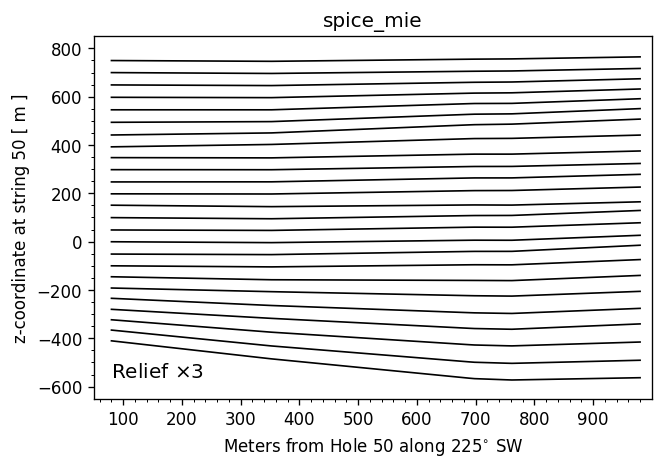

In [17]:
theta = np.deg2rad(tilt_dir)
ct = np.cos(theta)
st = np.sin(theta)

fig, ax = plt.subplots(dpi=120)

string = 66

drs = np.linspace(80, 980, 100)
for z in np.arange(-450, 800, 50):
    xref, yref = geo[string - 1, :, :2].mean()
    zs = []
    for dr in drs:
        x = x50 + dr * ct
        y = y50 + dr * st
        zs.append(z + zshift.GetValue(x, y, z))
    zs = np.array(zs)
    ax.plot(drs, 3*(zs - zs[0]) + zs[0], 'k-', lw=1)
    
ax.set_xlim(50, 1000)
ax.set_ylim(-650, 850)

ax.set_title(ice_model)
ax.set_xticks(np.arange(100, 901, 100), minor=False)
ax.set_xticks(np.arange(60, 1000, 20), minor=True)
ax.set_yticks(np.arange(-600, 801, 200), minor=False)
ax.set_yticks(np.arange(-600, 801, 50), minor=True)
ax.set_xlabel(r'Meters from Hole 50 along %.0f$^{\circ}$ SW' % tilt_dir)
ax.set_ylabel('z-coordinate at string 50 [ m ]')
ax.text(80, -500, r'Relief $\times$3', fontsize=12, va='top', ha='left')
pass